## Mounting google Drive 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Importing Keras, Tensorflow, neccessary libraries and loading offline preprocessed data


In [ ]:
import os
import cv2
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow import keras
from scipy.ndimage import rotate
import copy
import tensorflow as tf
import cv2 as cv
from keras.models import load_model
 

In [ ]:
#load preprocessed data
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
patients = np.load("/gdrive/My Drive/gp/offline-patient.npy")
tumors = np.load("/gdrive/My Drive/gp/offline-tumor.npy")
livers = np.load("/gdrive/My Drive/gp/offline-liver.npy")
np.load = np_load_old

## Model implemintation and loss function 
* Dice coefficient, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data

* U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.



In [ ]:
# input size
img_width = 256
img_hight = 256
img_channels = 1



# dice loss function
def soft_dice_loss(y_true, y_pred, epsilon=1e-5): 
  
    numerator = 2. * tf.reduce_sum(y_pred * y_true)
    denominator = tf.reduce_sum(y_pred + y_true)
    
    return 1 - (numerator / (denominator + epsilon))


# U Net
# Encoders

layer =  tf.keras.layers
inputs = layer.Input((img_width,img_hight,img_channels))


c1 = layer.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(inputs)
c1 = layer.Dropout(0.1)(c1)
c1 = layer.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c1)
p1 = layer.AveragePooling2D((2,2))(c1)


c2 = layer.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p1)
c2 = layer.Dropout(0.1)(c2)
c2 = layer.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c2)
p2 = layer.AveragePooling2D((2,2))(c2)


c3 = layer.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p2)
c3 = layer.Dropout(0.2)(c3)
c3 = layer.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c3)
p3 = layer.AveragePooling2D((2,2))(c3)


c4 = layer.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p3)
c4 = layer.Dropout(0.2)(c4)
c4 = layer.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c4)
p4 = layer.AveragePooling2D((2,2))(c4)

c5 = layer.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p4)
c5 = layer.Dropout(0.3)(c5)
c5 = layer.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c5)


#Decoders
u6 = layer.Conv2DTranspose(128, (2,2), strides=(2,2),padding='same')(c5)
u6 = layer.concatenate([u6,c4])
c6 = layer.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u6)
c6 = layer.Dropout(0.2)(c6)
c6 = layer.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c6)


u7 = layer.Conv2DTranspose(64, (2,2), strides=(2,2),padding='valid')(c6)
u7 = layer.concatenate([u7,c3])
c7 = layer.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u7)
c7 = layer.Dropout(0.2)(c7)
c7 = layer.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c7)


u8 = layer.Conv2DTranspose(32, (2,2), strides=(2,2),padding='valid')(c7)
u8 = layer.concatenate([u8,c2])
c8 = layer.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u8)
c8 = layer.Dropout(0.1)(c8)
c8 = layer.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c8)


u9 = layer.Conv2DTranspose(16, (2,2), strides=(2,2),padding='valid')(c8)
u9 = layer.concatenate([u9,c1],axis=3)
c9 = layer.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u9)
u9 = layer.Dropout(0.1)(c9)
c9 = layer.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c9)

outputs = layer.Conv2D(1,(1,1),activation='sigmoid')(c9)

LiverModel = tf.keras.Model(inputs=[inputs], outputs=[outputs])
LiverModel.compile(optimizer='adam', loss=soft_dice_loss , metrics = [tf.keras.metrics.MeanIoU(num_classes=2,name='Mean_IoU')])
LiverModel.summary()

TumorModel = tf.keras.Model(inputs=[inputs], outputs=[outputs])
TumorModel.compile(optimizer='adam', loss=soft_dice_loss , metrics = [tf.keras.metrics.MeanIoU(num_classes=2,name='Mean_IoU')])
TumorModel.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
_______________________________________________________________________________________

## Getting data ready to the model

* Resize data to [256,256]  

* Split data to Train, Test and Valid

In [ ]:
# resize data to 256*256 
patients_256 = []
tumors_256 = []
livers_256 = []
for i in range(15):
  p256 = []
  t256 = []
  l256 = []
  for j in range(len(tumors[i])):
    resized1 = cv2.resize(patients[i][j], (256,256), interpolation = cv2.INTER_AREA)
    resized2 = cv2.resize(livers[i][j], (256,256), interpolation = cv2.INTER_AREA)
    resized3 = cv2.resize(tumors[i][j], (256,256), interpolation = cv2.INTER_AREA)
    p256.append(resized1)
    l256.append(resized2)
    t256.append(resized3)
  patients_256.append(p256)
  livers_256.append(l256)
  tumors_256.append(t256)

In [ ]:
train_len = 0
test_len = 0
for i in range(12):
  train_len += len(patients_256[i])

for i in range(12,15):
  test_len += len(patients_256[i])


In [ ]:
# stac all slices to be ready for model 
x_train = np.zeros( (train_len, img_hight, img_width, img_channels), dtype=np.float32)
y_train = np.zeros( (train_len, img_hight, img_width, img_channels), dtype=np.float32)
y_train2 = np.zeros( (train_len, img_hight, img_width, img_channels), dtype=np.float32)

x_test = np.zeros( (test_len, img_hight, img_width, img_channels), dtype=np.float32)
y_test = np.zeros( (test_len, img_hight, img_width, img_channels), dtype=np.float32)
y_test2 = np.zeros( (test_len, img_hight, img_width, img_channels), dtype=np.float32)

count = 0
for i in range(12):
  for j,each_slice in enumerate(patients_256[i]):
    x_train[count] = patients_256[i][j].reshape((256,256,1))
    y_train[count] = tumors_256[i][j].reshape((256,256,1))
    y_train2[count] = livers_256[i][j].reshape((256,256,1))
    count+=1


count = 0
for i in range(12,15):
  for j,each_slice in enumerate(patients_256[i]):
    x_test[count] = patients_256[i][j].reshape((256,256,1))
    y_test[count] = tumors_256[i][j].reshape((256,256,1))
    y_test2[count] = livers_256[i][j].reshape((256,256,1))
    count+=1



2647
871


In [ ]:
#spiit data to tarin and valid
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(x_train, y_train, test_size=0.1, random_state=200)

## Model Training 
* Setting model checkpoint path, epochs and batch size
* Choosing between liver or tumor model to train 
* Model Training


In [ ]:
liver_model_path = "/gdrive/My Drive/gp/new-model-liver.h5"
tumor_model_path = "/gdrive/My Drive/gp/new-model-tumor.h5"

call = tf.keras.callbacks.ModelCheckpoint(tumor_model_path, verbose=1, save_best_only=True)
EPOCHS = 30
BS = 64

In [ ]:
#best liver and tumor models
TumorModel.load_weights('/gdrive/My Drive/gp/model-direct-tumor.h5')
#LiverModel.load_weights('/gdrive/My Drive/gp/LiverModel.h5')

In [ ]:
#Model = LiverModel
Model = TumorModel

In [ ]:
# train the network
trained = Model.fit( trainX, trainY, batch_size=BS ,validation_data=(validX, validY), epochs=EPOCHS, callbacks=call)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.0744 - Mean_IoU: 0.9312
Epoch 00001: val_loss improved from inf to 0.07122, saving model to /gdrive/My Drive/gp/new-model-tumor.h5
38/38 [==============================] - 13s 341ms/step - loss: 0.0744 - Mean_IoU: 0.9312 - val_loss: 0.0712 - val_Mean_IoU: 0.9385
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 0.0730 - Mean_IoU: 0.9323
Epoch 00002: val_loss did not improve from 0.07122
38/38 [==============================] - 12s 305ms/step - loss: 0.0730 - Mean_IoU: 0.9323 - val_loss: 0.0747 - val_Mean_IoU: 0.9345
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 0.0784 - Mean_IoU: 0.9313
Epoch 00003: val_loss did not improve from 0.07122
38/38 [==============================] - 12s 303ms/step - loss: 0.0784 - Mean_IoU: 0.9313 - val_loss: 0.0771 - val_Mean_IoU: 0.9339
Epoch 4/30
38/38 [==============================] - ETA: 0s - loss: 0.0777 - Mean_IoU: 0.9288
Epoch 00004: val_lo

## Model Testing
* Predicting test cases
* Score function with  Mean Intersiction over Union

In [ ]:
predict = Model.predict(x_test)
predict = (predict > 0.5).astype(np.uint8)

In [ ]:
# Score wwith mean intersection over union  (MIoU)
def score(predicted,true):
    predict = predicted/255
    y_train = true/255
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(predict, y_train)
    return m.result().numpy()


In [ ]:
print(score(predicted,y_test))

## Showing some of the test results

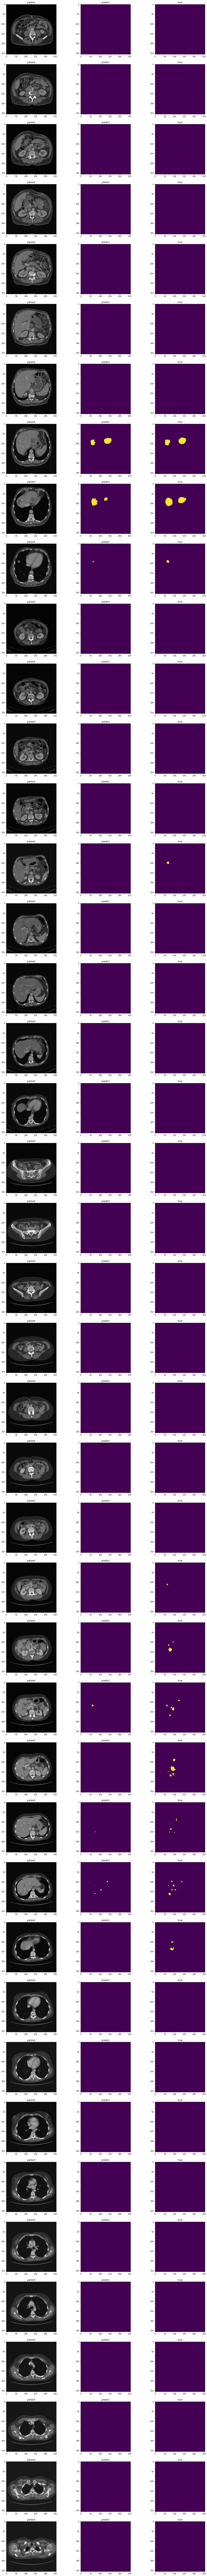

In [ ]:
#see results
f, ax = plt.subplots(len(predict)//20, 3, figsize=(20, 250))

for i in range (len(predict)//20) :

  ax[i][0].set_title(' patient ')
  ax[i][0].imshow(x_test[i*20].reshape((256, 256)), cmap='gray')
  
  ax[i][1].set_title(' predict ')
  ax[i][1].imshow(predict[i*20].reshape((256, 256)))

  ax[i][2].set_title(' true ')
  ax[i][2].imshow(y_test[i*20].reshape((256, 256)))


plt.show()